In [1]:
import sys
!{sys.executable} -m pip install yfinance


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class SMABacktester(): 
    def __init__(self, symbol, SMA_S, SMA_L, start, end):
        self.symbol = symbol
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.results = None
        self.get_data()

    def get_data(self):
        df = yf.download(self.symbol, start=self.start, end=self.end)
        if df.empty:
            print("No data was downloaded.")
            self.data2 = pd.DataFrame()
            return
        data = df[['Close']].copy()
        data["returns"] = np.log(data["Close"] / data["Close"].shift(1))
        data["SMA_S"] = data["Close"].rolling(self.SMA_S).mean()
        data["SMA_L"] = data["Close"].rolling(self.SMA_L).mean()
        data.dropna(inplace=True)
        self.data2 = data

    def test_results(self):
        if self.data2.empty:
            print("No data to test.Go and run get_data() again with valid inputs.")
            return None, None

        data = self.data2.copy()
        data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
        data["strategy"] = data["returns"] * data["position"].shift(1)
        data.dropna(inplace=True)

        if data.empty:
            print("Insufficient data after strategy calculation.")
            return None, None

        data["returnsbh"] = data["returns"].cumsum().apply(np.exp)
        data["returnsstrategy"] = data["strategy"].cumsum().apply(np.exp)

        if data["returnsstrategy"].empty or data["returnsbh"].empty:
            print("Empty results — check the strategy or SMA periods.")
            return None, None

        perf = data["returnsstrategy"].iloc[-1]
        outperf = perf - data["returnsbh"].iloc[-1]
        self.results = data

        ret = np.exp(data["strategy"].sum())
        std = data["strategy"].std() * np.sqrt(252)

        return round(perf-1, 6), round(outperf, 6)   # modified here

    def plot_results(self):
        if self.results is None or self.results.empty:
            print("Run test_results() first.")
        else:
            title = f"{self.symbol} | SMA_S={self.SMA_S} | SMA_L={self.SMA_L}"
            self.results[["returnsbh", "returnsstrategy"]].plot(title=title, figsize=(12, 8))
            plt.show()

    def calculate_metrics(self, benchmark_symbol="^NSEI"):
        if self.results is None:
            print("Run test_results() first.")
            return
        
        data = self.results.copy()
        
        # Cumulative Return
        cumulative_return = np.exp(data["strategy"].sum()) - 1
        
        # Annualized Return
        annualized_return = np.mean(data["strategy"]) * 252
        
        # Standard Deviation (Annualized)
        annualized_std = data["strategy"].std() * np.sqrt(252)
        
        # Sharpe Ratio (Assumes risk-free rate = 0)
        sharpe_ratio = annualized_return / annualized_std if annualized_std != 0 else np.nan
    
        # Sortino Ratio
        negative_std = data.loc[data["strategy"] < 0, "strategy"].std() * np.sqrt(252)
        sortino_ratio = annualized_return / negative_std if negative_std != 0 else np.nan
    
        # Maximum Drawdown
        cumulative = (data["strategy"] + 1).cumprod()
        running_max = cumulative.cummax()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()
    
        # Win Rate
        wins = data[data["strategy"] > 0].shape[0]
        total = data[data["strategy"] != 0].shape[0]
        win_rate = wins / total if total != 0 else np.nan
    
        # Profit Factor
        avg_profit = data.loc[data["strategy"] > 0, "strategy"].mean()
        avg_loss = data.loc[data["strategy"] < 0, "strategy"].mean()
        max_profit = data["strategy"].max()
        max_loss = data["strategy"].min()
        profit_factor = -avg_profit / avg_loss if avg_loss != 0 else np.nan
    
        # Benchmark Comparison (Nifty by default)
        benchmark_data = yf.download(benchmark_symbol, start=self.start, end=self.end)
        benchmark_data["returns"] = np.log(benchmark_data["Close"] / benchmark_data["Close"].shift(1))
        benchmark_data.dropna(inplace=True)
        
        # Align dates between backtest and benchmark
        common_dates = data.index.intersection(benchmark_data.index)
        aligned_data = data.loc[common_dates]
        aligned_benchmark_returns = benchmark_data["returns"].loc[common_dates]
        
        benchmark_cum_return = np.exp(aligned_benchmark_returns.sum()) - 1

    
        metrics = {
            "Cumulative Return": round(cumulative_return, 4),
            "Annualized Return": round(annualized_return, 4),
            "Sharpe Ratio": round(sharpe_ratio, 4),
            "Sortino Ratio": round(sortino_ratio, 4),
            "Max Drawdown": round(max_drawdown, 4),
            "Win Rate": round(win_rate, 4),
            "Profit Factor": round(profit_factor, 4),
            "Avg Profit": round(avg_profit, 6),
            "Avg Loss": round(avg_loss, 6),
            "Max Profit": round(max_profit, 6),
            "Max Loss": round(max_loss, 6),
            f"Benchmark ({benchmark_symbol}) Return": round(benchmark_cum_return, 4),
        }
    
        return pd.DataFrame.from_dict(metrics, orient="index", columns=["Value"])


In [4]:
tester = SMABacktester("RELIANCE.NS" , 50 , 252 , "2016-01-01", "2019-12-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
tester.test_results()

(1.878631, 0.0)

In [6]:
tester.calculate_metrics()

[*********************100%***********************]  1 of 1 completed


,Value
Cumulative Return,1.878600
Annualized Return,0.375300
Sharpe Ratio,1.432000
Sortino Ratio,2.426000
Max Drawdown,-0.228000
Win Rate,0.520500
Profit Factor,1.176200
Avg Profit,0.013226
Avg Loss,-0.011245
Max Profit,0.104027


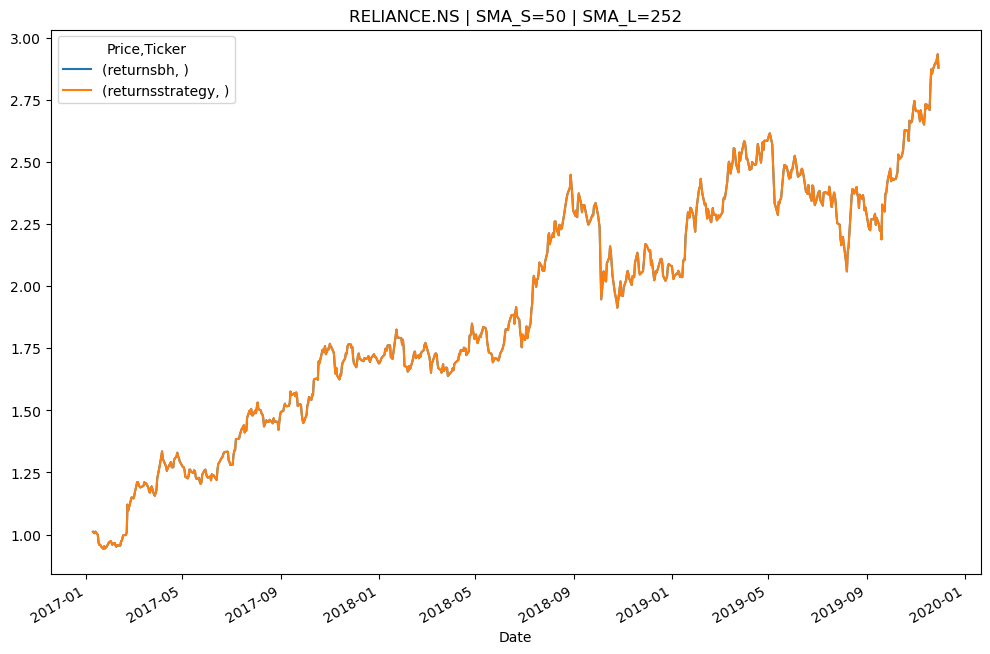

In [7]:
tester.plot_results()